# All model mask for index mask

In [2]:
import json
import warnings
from typing import Tuple
from datetime import date
import subprocess
import xarray as xr
import numpy as np
from dask.distributed import Client
from nmme_download import iri_nmme_models
from nmme_climo import read_nmme

In [2]:
### open local cluster
client = Client(n_workers=2,threads_per_worker=60,processes=False)

###### Setting ######
# specify date
today = date.today()
# setup the new output file name (same as date of download)
dateform = today.strftime("%y_%m_%d")

# directory where new simulation (inputs) and mhw forecast (outputs) is located
BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'

# directory where sst threshold/climatology/trend (inputs) is located
PREDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

# directory where nmme mhw probability is located
OUTDIR = '/Datasets.private/marinehw/nmme_mhw_prob/'

# output filename date, MHW prediction generated date
date = dateform

# MHW threshold for prediction
threshold = [90]


In [3]:
# used model list
with open('model_use_list.json','r',encoding='utf-8') as f:
    json_dict = json.load(f)
model_use_list = json_dict['model_use_list']

dict_model = iri_nmme_models()
avai_model_list = list(dict_model.keys())

In [4]:
dict_model

{'CanCM4i': ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanCM4i/.HINDCAST/.MONTHLY/.sst/dods',
  'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanCM4i/.FORECAST/.MONTHLY/.sst/dods'],
 'GEM-NEMO': ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GEM-NEMO/.HINDCAST/.MONTHLY/.sst/dods',
  'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GEM-NEMO/.FORECAST/.MONTHLY/.sst/dods'],
 'GFDL-SPEAR': ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.sst/dods',
  'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst/dods'],
 'NASA-GEOSS2S': ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.sst/dods',
  'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.sst/dods'],
 'COLA-RSMAS-CCSM4': ['http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.sst/dods'],
 'NCEP-CFSv2': ['http://iridl.ldeo.columb

In [5]:
avai_model_list

['CanCM4i',
 'GEM-NEMO',
 'GFDL-SPEAR',
 'NASA-GEOSS2S',
 'COLA-RSMAS-CCSM4',
 'NCEP-CFSv2',
 'CanCM4i-IC3',
 'GEM5-NEMO',
 'COLA-RSMAS-CESM1',
 'GFDL-SPEAR-regridded']

In [6]:
model_use_list

['CanCM4i-IC3',
 'GEM5-NEMO',
 'GFDL-SPEAR-regridded',
 'NASA-GEOSS2S',
 'COLA-RSMAS-CCSM4',
 'COLA-RSMAS-CESM1',
 'NCEP-CFSv2']

In [7]:
def read_nmme_onlist(
        model_list: list[str],
        all_model_list: list[str],
        basedir: str,
        predir: str
) -> dict:
    """read in the NMME for MHW detection

    Parameters
    ----------
    model_list : list[str]
        list of string of the model name one want to include
        in the MHW probability calculation
    all_model_list : list[str]
        list of string of all the avialable model name 
        on prem
    basedir : str
        directory path to the raw NMME model output
    predir : str
        directory path to the NMME model statistics
        (climatology, threshold, linear trend etc.)

    Returns
    -------
    dict
        'da_model_list': 
            a list of xr.DataArray that includes each model output cropped to the
            desired time period
        'da_climo_list':
            a list of xr.DataArray that includes each model climo
        'da_nmem_all_out':
            a xr.DataArray represents total member of all models used
        'da_allmodel_mask':
            a xr.DataArray represents mask for every S, L, X, Y 
            (if "model" number less than 2 will be masked)
    """


    # read user input
    da_nmem_list = []
    da_model_list = []
    da_climo_list = []
    for modelname in model_list:
        if modelname in all_model_list:

            # construct model list
            forecast_files = f'{basedir}{modelname}_forecast_??_??_??_??????.nc'
            climo_file = f'{predir}{modelname}_climo.nc'

            print('------------')
            print(modelname)
            print('------------')


            # lazy loading all dataset
            ds_nmme = read_nmme(
                forecast_files = forecast_files,
                model = modelname,
                chunks={'M':1,'L':1,'S':1}
            )
            # crop to only calculate the probability after 2020 (after Mike J's file)
            ds_nmme = ds_nmme.where(ds_nmme['S.year']>2020,drop=True)

            da_model = ds_nmme['sst']

            # read climatology (1991-2020)
            da_ensmean_climo = xr.open_dataset(climo_file,chunks={'S':1,'L':1})['sst']

            # calculate ensemble member in each model
            da_nmem = da_model.where(da_model.isnull(), other=1).sum(dim=['M'])
            da_nmem = da_nmem.where(da_nmem>0)

            # stored all models in one list
            da_nmem_list.append(da_nmem)           # number of ensemble member
            da_model_list.append(da_model)         # model output
            da_climo_list.append(da_ensmean_climo) # model climatology

    # combined all model into one dataset
    da_nmem_all = xr.concat(da_nmem_list,dim='model',join='outer')

    # create mask for every S, L, X, Y (if model number less than 2 will be masked)
    da_nmodel = (da_nmem_all/da_nmem_all).sum(dim='model')
    da_nmodel_mask = da_nmodel.where(da_nmodel>1)
    da_allmodel_mask = da_nmodel_mask.where(da_nmodel_mask.isnull(),other=1).compute()

    # calculate total member of all model
    da_nmem_all_out = (da_nmem_all*da_allmodel_mask).sum(dim='model').compute()

    return {
        'da_model_list':da_model_list,
        'da_climo_list':da_climo_list,
        'da_nmem_all_out':da_nmem_all_out,
        'da_allmodel_mask':da_allmodel_mask
    }

In [8]:
dict_da = read_nmme_onlist(model_use_list,avai_model_list,BASEDIR,PREDIR)

------------
CanCM4i-IC3
------------
reading data
------------
GEM5-NEMO
------------
reading data
------------
GFDL-SPEAR-regridded
------------
reading data
variable name convert from sst_regridded to sst
------------
NASA-GEOSS2S
------------
reading data
------------
COLA-RSMAS-CCSM4
------------
reading data
------------
COLA-RSMAS-CESM1
------------
reading data
------------
NCEP-CFSv2
------------
reading data


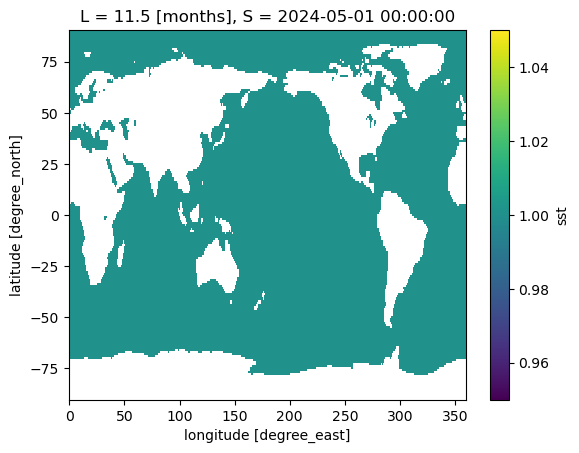

In [11]:
dict_da['da_allmodel_mask'].isel(S=-1,L=-1).plot()

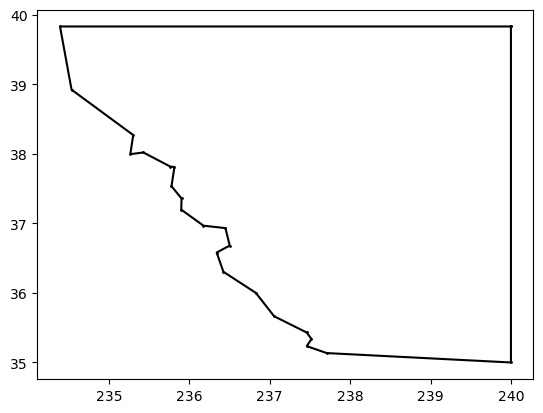

In [53]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
import shapefile as shp

res = 'l'
sf = shp.Reader(f'/home/chsu/data/gshhg-shp-2/GSHHS_shp/{res}/GSHHS_{res}_L1')

import numpy as np
x_list = []
y_list = []
x_lim = [-130,-120]
y_lim = [35,40]
for nf,feature in enumerate(sf.shapeRecords()):
    x=[]
    y=[]
    for i in feature.shape.points[:]:
        if i[0]>=x_lim[0] and i[0]<=x_lim[-1] and i[1]>=y_lim[0] and i[1]<=y_lim[-1]:
            if nf == 3:
                x.append(i[0])
                y.append(i[1])
    x_list += x
    y_list += y

x_list = np.array(x_list)
y_list = np.array(y_list)
x_list_new = np.concatenate([x_list[0:15],x_list[27:]])
y_list_new = np.concatenate([y_list[0:15],y_list[27:]])

import numpy as np

def deg_to_rad(degree):
    return degree*np.pi/180.

def rad_to_deg(radian):
    return radian*180./np.pi

def distance_along_lat(delta_longitude,latitude):
    earth_radius = 6371.  # km
    delta_distance = (
        earth_radius
        *np.cos(deg_to_rad(latitude))
        *deg_to_rad(delta_longitude)
    )
    return delta_distance

def delta_lon_along_lat(delta_distance,latitude):
    earth_radius = 6371.  # km
    delta_longitude_rad = (
        delta_distance/earth_radius/np.cos(deg_to_rad(latitude))
    )

    return rad_to_deg(delta_longitude_rad)

def polygon_off_coast(distance,lon_list,lat_list,eastward_ext=False):
    if eastward_ext:
        lon_list_extend = lon_list + delta_lon_along_lat(distance,lat_list)
    else: 
        lon_list_extend = lon_list - delta_lon_along_lat(distance,lat_list)

    # lon_list_poly = np.concatenate([lon_list,lon_list_extend[::-1],np.array([lon_list[0]])])
    # lat_list_poly = np.concatenate([lat_list,lat_list[::-1],np.array([lat_list[0]])])

    # point orientation: top right point, x away from coastline,  bottom right, top right
    lon_list_poly = np.concatenate([np.array([x_lim[1]]),lon_list_extend[::-1],np.array([x_lim[1]]),np.array([x_lim[1]])])
    lat_list_poly = np.concatenate([np.array([lat_list[-1]]),lat_list[::-1],np.array([y_lim[0]]),np.array([lat_list[-1]])])

    indi = np.where(lon_list_poly<0)
    lon_list_poly[indi] = lon_list_poly[indi]+360.

    poly_list = []
    for i, lon in enumerate(lon_list_poly):
        poly_list.append((lon,lat_list_poly[i]))
    poly = Polygon(poly_list)

    return {
        'lon':lon_list_poly,
        'lat':lat_list_poly,
        'polygon':poly
    }

def polygon_inland(distance,lon_list,lat_list,eastward_ext=False,outpoint = [-120,31]):
    if eastward_ext:
        lon_list_extend = lon_list + delta_lon_along_lat(distance,lat_list)
    else: 
        lon_list_extend = lon_list - delta_lon_along_lat(distance,lat_list)

    # point orientation:  x inland from coastline,top left, bottoom left, bottom right
    lon_list_poly = np.concatenate([lon_list_extend,np.array([outpoint[0]]),np.array([outpoint[0]]),np.array([lon_list_extend[0]])])
    lat_list_poly = np.concatenate([lat_list,np.array([lat_list[-1]]),np.array([outpoint[1]]),np.array([lat_list[0]])])

    indi = np.where(lon_list_poly<0)
    lon_list_poly[indi] = lon_list_poly[indi]+360.

    poly_list = []
    for i, lon in enumerate(lon_list_poly):
        poly_list.append((lon,lat_list_poly[i]))
    poly = Polygon(poly_list)

    return {
        'lon':lon_list_poly,
        'lat':lat_list_poly,
        'polygon':poly
    }

dict_poly_150 = polygon_off_coast(150.,x_list_new,y_list_new,eastward_ext=False)
dict_poly_75 = polygon_off_coast(75.,x_list_new,y_list_new,eastward_ext=False)


import matplotlib.pyplot as plt
plt.plot(dict_poly_150['lon'],dict_poly_150['lat'],'ko-',markersize=1)

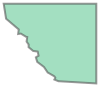

In [54]:
dict_poly_150['polygon']

In [74]:
dict_da['da_allmodel_mask']

<xarray.DataArray 'sst' (S: 41, L: 12, Y: 181, X: 360)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.]]]], dtype=float32)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 2021-01-01 00:00:00 ... 2024-05-01 00:00:00
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0

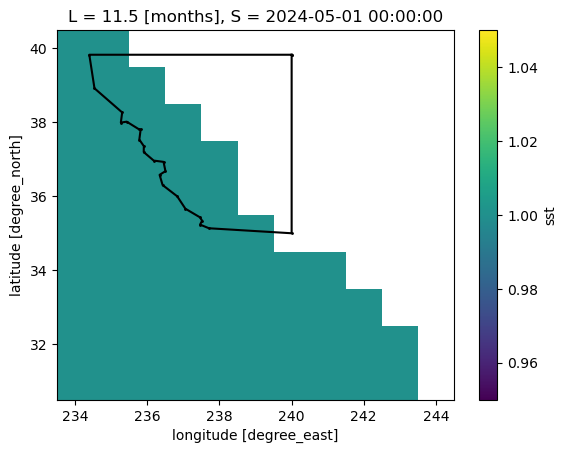

In [38]:
da_mask = dict_da['da_allmodel_mask'].isel(S=-1,L=-1)
da_mask = da_mask.where((da_mask.X>-127+360)&(da_mask.X<-115+360)&(da_mask.Y>30)&(da_mask.Y<41),drop=True)
da_mask.plot()
plt.plot(dict_poly_150['lon'],dict_poly_150['lat'],'ko-',markersize=1)

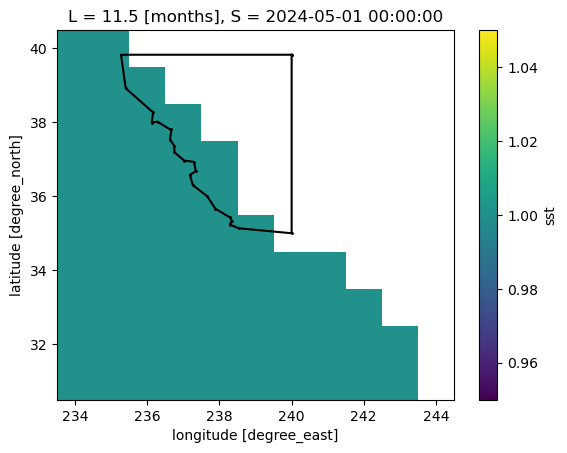

In [39]:
da_mask.plot()
plt.plot(dict_poly_75['lon'],dict_poly_75['lat'],'ko-',markersize=1)

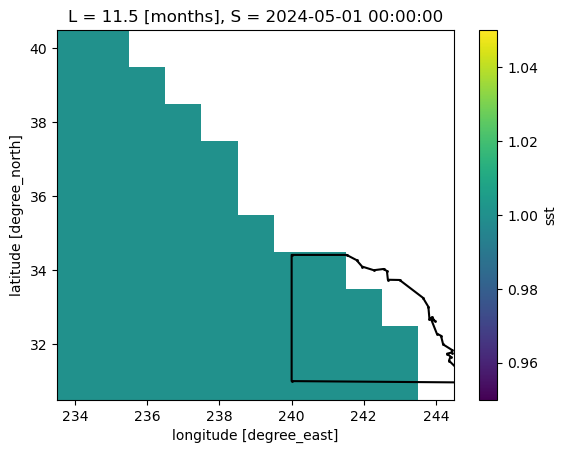

In [56]:
x_list = []
y_list = []
x_lim = [-120.45,-115]
y_lim = [30.9,36]
outpoint = [-120,31]
for nf,feature in enumerate(sf.shapeRecords()):
    x=[]
    y=[]
    for i in feature.shape.points[:]:
        if i[0]>=x_lim[0] and i[0]<=x_lim[-1] and i[1]>=y_lim[0] and i[1]<=y_lim[-1]:
            if nf == 3:
                x.append(i[0])
                y.append(i[1])
    x_list += x
    y_list += y

x_list = np.array(x_list)
y_list = np.array(y_list)

dict_poly_inland = polygon_inland(100.,x_list,y_list,eastward_ext=True,outpoint = outpoint)


import matplotlib.pyplot as plt
da_mask.plot()
plt.plot(dict_poly_inland['lon'],dict_poly_inland['lat'],'ko-',markersize=1)

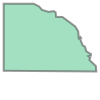

In [57]:
dict_poly_inland['polygon']

In [59]:
da_mask

<xarray.DataArray 'sst' (Y: 10, X: 11)>
array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=float32)
Coordinates:
    L        float32 11.5
    S        object 2024-05-01 00:00:00
  * X        (X) float32 234.0 235.0 236.0 237.0 ... 241.0 242.0 243.0 244.0
  * Y        (Y) float32 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0

In [60]:
lim_lon_array = da_mask.X.data
lim_lat_array = da_mask.Y.data
polygons = [
    dict_poly_150['polygon'],
    dict_poly_75['polygon'],
    dict_poly_inland['polygon']
]
da_masks = []

for polygon in polygons:
    da_mask_region = da_mask.copy()*np.nan
    for lon in lim_lon_array:
        for lat in lim_lat_array:
            if da_mask.sel(X=lon,Y=lat).data == 1:
                point = Point(lon, lat)
                if polygon.contains(point):
                    ii = np.where(lim_lon_array==lon)[0]
                    jj = np.where(lim_lat_array==lat)[0]
                    da_mask_region[jj,ii] = 1
    da_masks.append(da_mask_region)

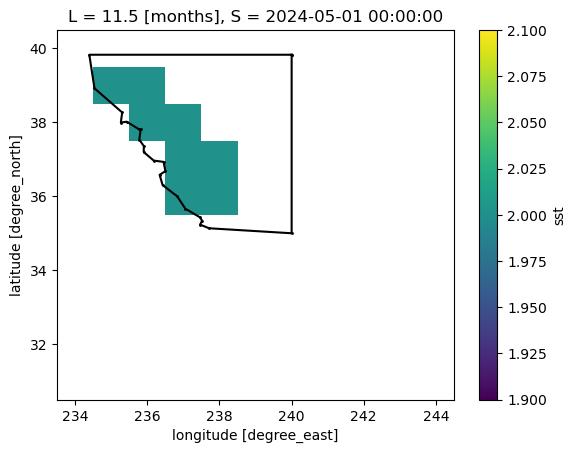

In [68]:
plt.plot(dict_poly_150['lon'],dict_poly_150['lat'],'ko-',markersize=1)
(da_masks[0]+1).plot()

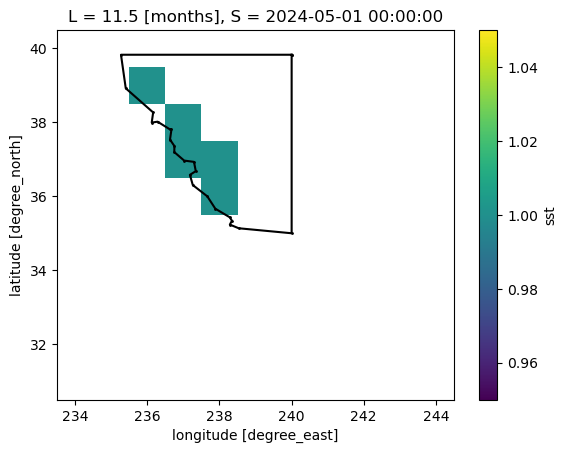

In [69]:
plt.plot(dict_poly_75['lon'],dict_poly_75['lat'],'ko-',markersize=1)
da_masks[1].plot()

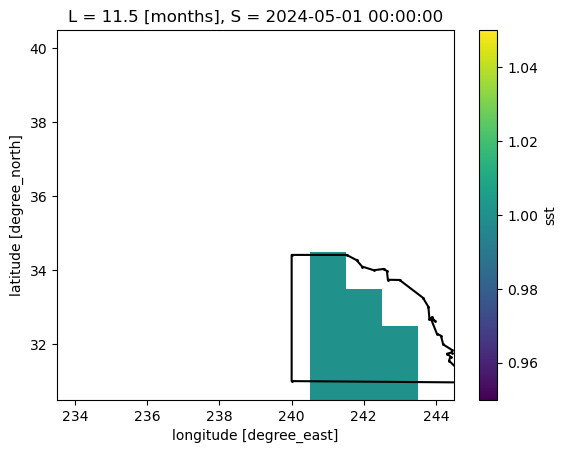

In [70]:

plt.plot(dict_poly_inland['lon'],dict_poly_inland['lat'],'ko-',markersize=1)
da_masks[2].plot()

In [3]:
ds = xr.open_dataset('/Datasets.private/marinehw/nmme_marine_index_mask/hci_total_mask.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:    (X: 11, Y: 10)
Coordinates:
  * X          (X) float32 234.0 235.0 236.0 237.0 ... 241.0 242.0 243.0 244.0
  * Y          (Y) float32 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0
Data variables:
    HCI_150km  (Y, X) float32 ...
    HCI_75km   (Y, X) float32 ...
    TOTAL      (Y, X) float32 ...

In [5]:
ds['HCI_150km']

<xarray.DataArray 'HCI_150km' (Y: 10, X: 11)>
[110 values with dtype=float32]
Coordinates:
  * X        (X) float32 234.0 235.0 236.0 237.0 ... 241.0 242.0 243.0 244.0
  * Y        (Y) float32 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0

In [103]:
ds['HCI_150km'].drop_vars(['S','L'])

<xarray.DataArray 'HCI_150km' (Y: 10, X: 11)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan,  1.,  1., nan, nan, nan, nan, nan, nan],
       [nan, nan, nan,  1.,  1., nan, nan, nan, nan, nan, nan],
       [nan, nan,  1.,  1., nan, nan, nan, nan, nan, nan, nan],
       [nan,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=float32)
Coordinates:
  * X        (X) float32 234.0 235.0 236.0 237.0 ... 241.0 242.0 243.0 244.0
  * Y        (Y) float32 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0

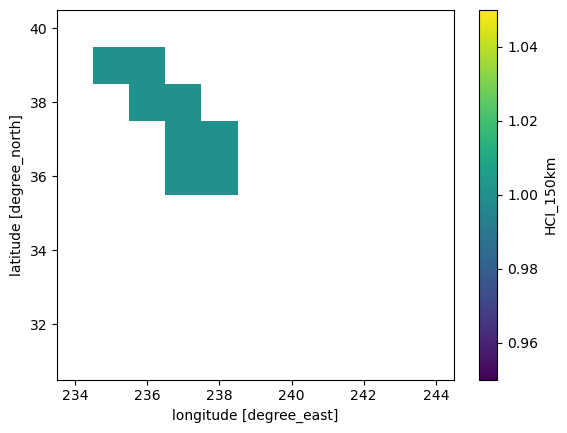

In [6]:
ds['HCI_150km'].plot()

# single model testing index

In [1]:
# %%
"""
# NMME Marine Heat Wave
 
The script calculate the HCI threshold based on 
Brodie et al., [2023]

Using NMME model hindcast and forecast obtained from 
http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/
with variable SST

"""


# %%
# start a local cluster
import sys
import warnings
import numpy as np
import xarray as xr
from dask.distributed import Client
from nmme_download import iri_nmme_models
from nmme_climo import nmme_ens_climo,read_nmme

warnings.simplefilter("ignore")

def read_marine_index_mask(mask_dir:str)->xr.Dataset:
    """read mask file into xr.Dataset

    Parameters
    ----------
    mask_dir : str
        directory string to the mask file

    Returns
    -------
    xr.Dataset
        The mask stored in the xr.Dataset
    """
    return xr.open_dataset(f'{mask_dir}hci_total_mask.nc')




In [2]:


client = Client(n_workers=1,threads_per_worker=60,processes=False)
print(client)
print(client.cluster.dashboard_link)

BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'
MASKDIR = '/Datasets.private/marinehw/nmme_marine_index_mask/'
OUTPUTDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

dict_model = iri_nmme_models()
avai_model_list = list(dict_model.keys())

# read user input
model_list = []
model_name = 'CanCM4i-IC3'
if model_name in avai_model_list:
    model_list.append(str(model_name))
    print(f'{model_name} exist, add to process list')
else:
    print(f'{model_name} does not exist')
    print(f'Make sure pick model from {avai_model_list}')

# construct model list
forecast_nmme_files = f'{BASEDIR}{model_name}_forecast_??_??_??_??????.nc'

# consistent climatology period
climatology_period = [1991,2020]

print('-------------')
print(model_name)
print('-------------')
ds_nmme = read_nmme(
    forecast_files = forecast_nmme_files,
    model = model_name
)


<Client: 'inproc://10.173.16.4/775869/1' processes=1 threads=60, memory=0.98 TiB>
http://10.173.16.4:8787/status
CanCM4i-IC3 exist, add to process list
-------------
CanCM4i-IC3
-------------
reading data


In [3]:
ds_nmme = ds_nmme.where(
    (ds_nmme['S.year']>=climatology_period[0])&
    (ds_nmme['S.year']<=climatology_period[1]),
    drop=True
)

ds_mask = read_marine_index_mask(MASKDIR)
da_hci = ds_mask['HCI_75km']*ds_nmme['sst']



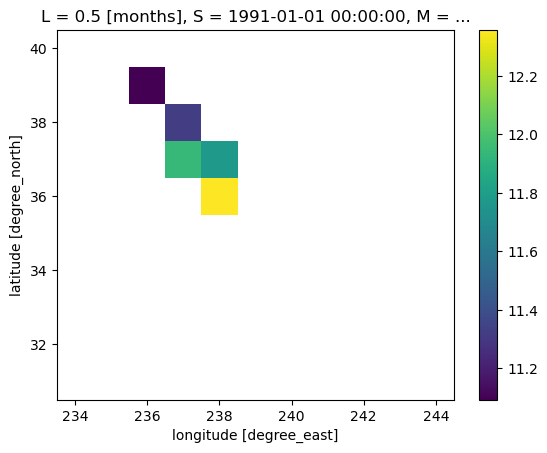

In [4]:
da_hci.isel(S=0,M=0,L=0).plot()

In [5]:
# calculate area weight
weights = np.cos(np.deg2rad(da_hci.Y))
weights.name = "weights"
# calculate area weighted mean
da_hci_ts = da_hci.weighted(weights).mean(dim=["X","Y"])
da_hci_ts_test = da_hci.mean(dim=["X","Y"])



In [6]:
da_hci_ts.isel(S=0,M=0,L=0).compute().data


array(11.7037325, dtype=float32)

In [7]:
da_hci_ts_test.isel(S=0,M=0,L=0).compute().data

array(11.697729, dtype=float32)

In [8]:
ds_hci_ts = xr.Dataset()
ds_hci_ts['hci_threshold'] = da_hci_ts

print('calculating climatology')
ds_ensmean_climo = nmme_ens_climo(ds_hci_ts,climo_dim='S',ens_dim='M')

calculating climatology


In [9]:
ds_ensmean_climo.isel(month=0,L=0).hci_threshold.compute().data

array(12.49614, dtype=float32)

In [10]:
climo_file = f'{OUTPUTDIR}{model_name}_climo.nc'
da_ensmean_climo = xr.open_dataset(climo_file,chunks={'S':1,'L':1})['sst']

da_total = ds_mask['TOTAL']*(ds_nmme['sst'].groupby('S.month')-da_ensmean_climo)
# calculate area weight
weights = np.cos(np.deg2rad(da_total.Y))
weights.name = "weights"
# calculate area weighted mean
da_total_ts = da_total.weighted(weights).mean(dim=["X","Y"])

# calculate the 6-month rolling mean of the previous six month
da_total_ts_6mon = da_total_ts.rolling(S=6, center=False).mean()

# the rolling mean of six month is put in the last month of the six
#  shift 1 is needed to let the rolling mean represent the monthly
#  value the is 1 month after the six month window
da_total_ts_6mon_shift = da_total_ts_6mon.shift(S=1)


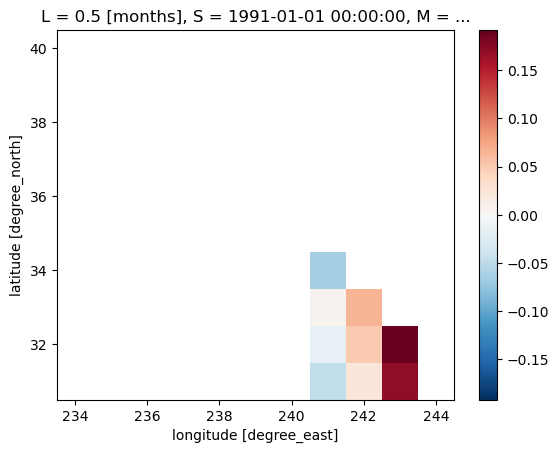

In [11]:
da_total.isel(S=0,M=0,L=0).plot()

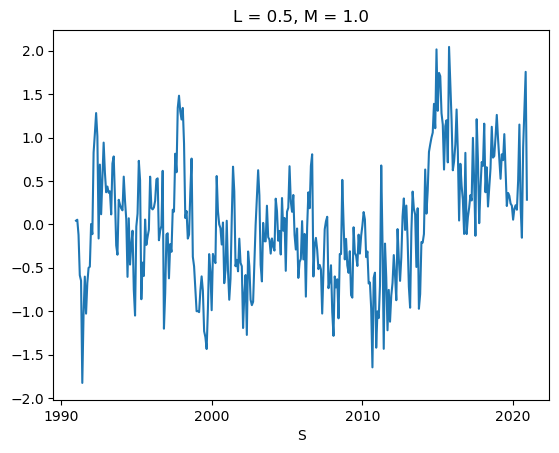

In [40]:
da_total_ts.isel(M=0,L=0).plot()

In [41]:
test = da_total_ts.isel(M=0,L=0).compute().data

In [42]:
np.mean(test[0:6])

-0.5147671

In [43]:
da_total_ts_6mon.isel(M=0,L=0).compute().data


array([            nan,             nan,             nan,             nan,
                   nan, -5.14767110e-01, -6.94419384e-01, -8.03646863e-01,
       -9.54822004e-01, -9.70046818e-01, -9.45501089e-01, -7.22292483e-01,
       -5.49144864e-01, -4.67684239e-01, -1.58323541e-01,  1.28542468e-01,
        4.25837427e-01,  6.76359832e-01,  6.48609757e-01,  7.82215178e-01,
        6.63682342e-01,  5.80677748e-01,  5.23941457e-01,  4.54286486e-01,
        5.43062449e-01,  5.00966370e-01,  5.42203009e-01,  5.14604151e-01,
        3.76709342e-01,  3.93950611e-01,  4.62697536e-01,  4.41881448e-01,
        3.40792865e-01,  2.19094679e-01,  2.47209668e-01,  1.68210983e-01,
        6.84694424e-02,  4.35989313e-02,  1.75679445e-01,  2.79337645e-01,
        2.42065296e-01,  1.03420705e-01,  8.44312832e-02, -1.97236985e-02,
       -1.50971830e-01, -2.08595559e-01, -3.43983412e-01, -4.18331057e-01,
       -4.34315175e-01, -3.36578876e-01, -1.74960211e-01, -7.79621899e-02,
       -9.62842181e-02,  

In [36]:
da_total_ts_6mon.isel(M=0,L=0).compute().data

array([       nan,        nan,        nan,        nan,        nan,
              nan, 15.89516  , 16.540014 , 17.39989  , 18.123287 ,
       18.67227  , 18.76179  , 18.55136  , 17.900002 , 17.012358 ,
       16.447145 , 16.169804 , 16.402124 , 17.086288 , 17.883043 ,
       18.985754 , 19.741793 , 20.222996 , 20.231234 , 19.727938 ,
       18.992208 , 17.981007 , 17.147673 , 16.555864 , 16.352997 ,
       16.803877 , 17.69713  , 18.64542  , 19.418901 , 19.861414 ,
       19.954498 , 19.441862 , 18.517614 , 17.52364  , 16.781149 ,
       16.320599 , 16.218353 , 16.51335  , 17.318865 , 18.183815 ,
       18.927137 , 19.433722 , 19.363306 , 18.85532  , 18.01483  ,
       17.143461 , 16.43051  , 15.963299 , 15.880005 , 16.415379 ,
       17.14517  , 18.102976 , 18.816122 , 19.271742 , 19.470135 ,
       19.201502 , 18.507523 , 17.557886 , 16.75512  , 16.26007  ,
       16.29186  , 16.72223  , 17.484745 , 18.413097 , 19.252409 ,
       19.874067 , 19.652327 , 18.998213 , 18.1848   , 17.2106

In [44]:
da_total_ts_6mon_shift.isel(M=0,L=0)

<xarray.DataArray (S: 360)>
dask.array<getitem, shape=(360,), dtype=float32, chunksize=(6,), chunktype=numpy.ndarray>
Coordinates:
    L        float32 0.5
  * S        (S) object 1991-01-01 00:00:00 ... 2020-12-01 00:00:00
    M        float32 1.0
    month    (S) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 1 2 3 4 5 6 7 8 9 10 11 12

In [12]:
%%time
import importlib
import mhw_nmme_threshold
importlib.reload(mhw_nmme_threshold)
da_total_threshold_git = mhw_nmme_threshold.nmme_total_quantile(
    da_total_ts_6mon_shift,
    total_threshold=75
)

: 

In [62]:
%%time
import importlib
import mhw_nmme_threshold
importlib.reload(mhw_nmme_threshold)
da_total_threshold = mhw_nmme_threshold.nmme_1mon_ts_quantile(
            da_total_ts_6mon_shift,
            total_threshold=75
        ).compute()


2024-06-04 15:21:10,213 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-06-04 15:21:12,132 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-06-04 15:21:13,532 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-06-04 15:21:16,267 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-06-04 15:21:26,420 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-06-04 15:21:40,273 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-06-04 15:21:55,899 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-06-04 15:22:12,661 - distributed.utils_perf - WARNING - full garbage collections took

In [63]:
da_total_threshold

<xarray.DataArray (month: 12, L: 12)>
array([[0.33606968, 0.22957533, 0.25112277, 0.27373356, 0.25971138,
        0.26739854, 0.22526034, 0.21029416, 0.17874464, 0.17546805,
        0.17182123, 0.15041354],
       [0.27197709, 0.25376663, 0.25448836, 0.24787768, 0.24251472,
        0.25745051, 0.20271732, 0.19680963, 0.17966466, 0.19249454,
        0.19411268, 0.17710413],
       [0.21875351, 0.23508272, 0.21385907, 0.23727569, 0.24424309,
        0.2087338 , 0.18785163, 0.18076697, 0.19079237, 0.19632124,
        0.19284098, 0.1709116 ],
       [0.21752394, 0.25414508, 0.26690007, 0.2881517 , 0.216852  ,
        0.22849112, 0.19115188, 0.18912919, 0.18619535, 0.21900265,
        0.16738991, 0.18453136],
       [0.29516758, 0.29133324, 0.26927222, 0.25907766, 0.21410508,
        0.21397544, 0.1699426 , 0.17820753, 0.20343637, 0.21428804,
        0.22887169, 0.21956389],
       [0.34469903, 0.31737272, 0.23960306, 0.21704869, 0.22910844,
        0.21358107, 0.16874736, 0.18729035, 0.20860265, 0.22357462,
        0.2270088 , 0.21092641],
       [0.41768605, 0.30778954, 0.24259333, 0.18430967, 0.18598508,
        0.20006735, 0.21906424, 0.21158247, 0.2341615 , 0.20877339,
        0.20110654, 0.22737081],
       [0.402002  , 0.31255195, 0.24365485, 0.20186   , 0.21881807,
        0.21713996, 0.21080064, 0.25045989, 0.26169576, 0.22648146,
        0.19323191, 0.21935856],
       [0.39558217, 0.31035629, 0.22448257, 0.23038103, 0.21921569,
        0.23712373, 0.2447453 , 0.27138969, 0.25312869, 0.25315934,
        0.22099464, 0.21601778],
       [0.43225922, 0.29220717, 0.25587863, 0.227255  , 0.27461588,
        0.26720101, 0.26554496, 0.25850143, 0.25314209, 0.22079985,
        0.20689796, 0.21445328],
       [0.4327575 , 0.2648509 , 0.26276776, 0.27429292, 0.28909928,
        0.28630026, 0.2706456 , 0.25070322, 0.24259695, 0.24686793,
        0.18574557, 0.18438122],
       [0.45741821, 0.28253172, 0.28553414, 0.31449442, 0.29642159,
        0.29934619, 0.21802793, 0.24202847, 0.23377725, 0.22467868,
        0.18255705, 0.20577051]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5

In [2]:
import xarray as xr
ds_hci_threshold = xr.open_dataset('/Datasets.private/marinehw/nmme_sst_stat/CanCM4i-IC3_climo_threshold_hci.nc')

In [7]:
ds_hci_threshold

<xarray.Dataset>
Dimensions:        (L: 12, month: 12)
Coordinates:
  * L              (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    hci_threshold  (month, L) float32 ...

In [3]:
# %%
"""
# NMME Marine Heat Wave
 
The script calculate the HCI threshold based on 
Brodie et al., [2023]

Using NMME model hindcast and forecast obtained from 
http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/
with variable SST

"""


# %%
# start a local cluster
import sys
import warnings
import numpy as np
import xarray as xr
from dask.distributed import Client
from nmme_download import iri_nmme_models
from nmme_climo import nmme_ens_climo,read_nmme

warnings.simplefilter("ignore")

def read_marine_index_mask(mask_dir:str)->xr.Dataset:
    """read mask file into xr.Dataset

    Parameters
    ----------
    mask_dir : str
        directory string to the mask file

    Returns
    -------
    xr.Dataset
        The mask stored in the xr.Dataset
    """
    return xr.open_dataset(f'{mask_dir}hci_total_mask.nc')




client = Client(n_workers=1,threads_per_worker=60,processes=False)
print(client)
print(client.cluster.dashboard_link)

BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'
MASKDIR = '/Datasets.private/marinehw/nmme_marine_index_mask/'
OUTPUTDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

dict_model = iri_nmme_models()
avai_model_list = list(dict_model.keys())

# read user input
model_list = []
model_name = 'CanCM4i-IC3'
if model_name in avai_model_list:
    model_list.append(str(model_name))
    print(f'{model_name} exist, add to process list')
else:
    print(f'{model_name} does not exist')
    print(f'Make sure pick model from {avai_model_list}')

# construct model list
forecast_nmme_files = f'{BASEDIR}{model_name}_forecast_??_??_??_??????.nc'

# consistent climatology period
climatology_period = [1991,2020]

print('-------------')
print(model_name)
print('-------------')
ds_nmme = read_nmme(
    forecast_files = forecast_nmme_files,
    model = model_name
)


<Client: 'inproc://10.173.16.4/826036/1' processes=1 threads=60, memory=0.98 TiB>
http://10.173.16.4:8787/status
CanCM4i-IC3 exist, add to process list
-------------
CanCM4i-IC3
-------------
reading data


In [4]:
ds_mask = read_marine_index_mask(MASKDIR)
da_hci = ds_mask['HCI_150km']*ds_nmme['sst']

In [13]:
ds_mask['HCI_150km'].sum()

<xarray.DataArray 'HCI_150km' ()>
array(8., dtype=float32)

In [5]:
da_hci

<xarray.DataArray (Y: 10, X: 11, S: 401, M: 10, L: 12)>
dask.array<multiply, shape=(10, 11, 401, 10, 12), dtype=float32, chunksize=(10, 11, 1, 10, 12), chunktype=numpy.ndarray>
Coordinates:
  * X        (X) float32 234.0 235.0 236.0 237.0 ... 241.0 242.0 243.0 244.0
  * Y        (Y) float32 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * S        (S) object 1991-01-01 00:00:00 ... 2024-05-01 00:00:00
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0

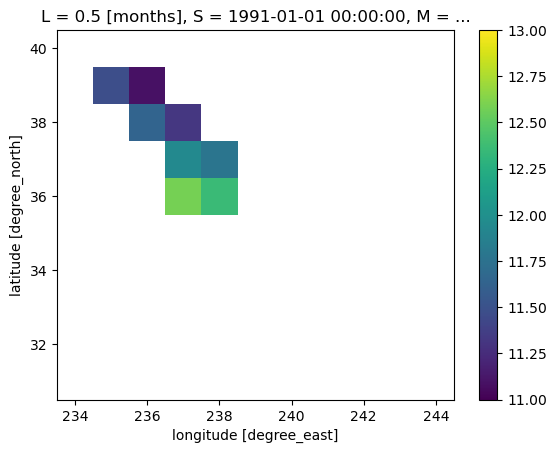

In [10]:
da_hci.isel(S=0,M=0,L=0).plot(vmin=11,vmax=13)

In [8]:
da_hci_low = da_hci.where(
        da_hci.groupby('S.month')<=ds_hci_threshold['hci_threshold']
    )



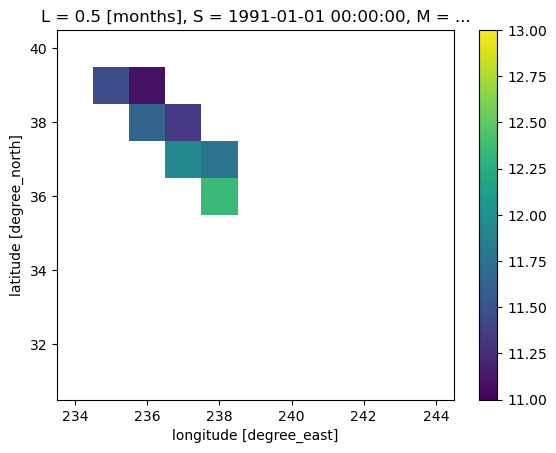

In [11]:
da_hci_low.isel(S=0,M=0,L=0).plot(vmin=11,vmax=13)

In [17]:
da_hci_sum = (
    da_hci_low
    .where(da_hci_low.isnull(),other=1)
    .sum(dim=['M','X','Y'],skipna=True))

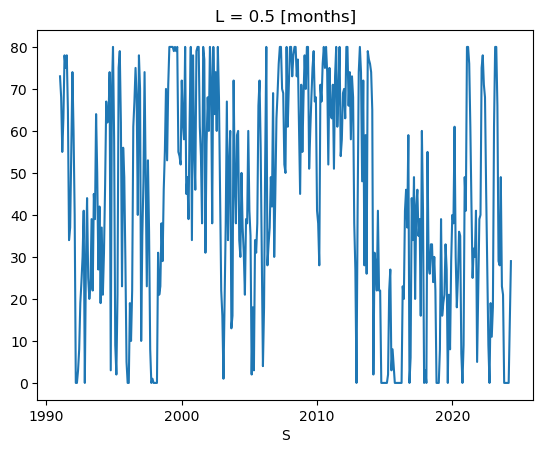

In [19]:
da_hci_sum.isel(L=0).plot()

In [16]:
da_hci_low.M.max()

<xarray.DataArray 'M' ()>
array(10., dtype=float32)

In [20]:
aa = 'NMME_prob90_detrend_24_05_21.nc'
aa[:-11]

'NMME_prob90_detrend_'